# Import Library

In [1]:
!pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 3.7 MB/s eta 0:00:00


In [2]:
import os
import shutil
import holidays
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from google.colab import drive

# Library Statistik untuk EDA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Preprocessing & Metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error

# Deep Learning (TensorFlow)
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Tuning
import keras_tuner as kt

print("Library berhasil diimpor.")

Library berhasil diimpor.


# Data Preparation

## Load Data

In [3]:
drive.mount('/content/drive')

base_path = '/content/drive/MyDrive/Magang Prima PTKI/data_dummy'

Mounted at /content/drive


In [4]:
# Load Data
transactions_df = pd.read_csv(os.path.join(base_path, 'transactions.csv'))
transaction_details_df = pd.read_csv(os.path.join(base_path, 'transaction_details.csv'))
products_df = pd.read_csv(os.path.join(base_path, 'products.csv'))
stores_df = pd.read_csv(os.path.join(base_path, 'stores.csv'))

## Merging Data

In [5]:
# Merging
df_merged = pd.merge(transactions_df, transaction_details_df, left_on='id', right_on='transactionId')
df_merged = pd.merge(df_merged, products_df[['id', 'productCategoryId']], left_on='productId', right_on='id', suffixes=('', '_prod'))
df_merged = pd.merge(df_merged, stores_df[['id', 'storeTypeId']], left_on='storeId', right_on='id', suffixes=('', '_store'))

In [6]:
# Filter Store ID 13 (Mainan dan Hobi)
TARGET_STORE_ID = 13
df_hobby = df_merged[df_merged['storeId'] == TARGET_STORE_ID].copy()
df_hobby['transactionDate'] = pd.to_datetime(df_hobby['transactionDate'])

## Data Cleaning

In [7]:
# Agregasi Harian
time_series_hobby = df_hobby.groupby(df_hobby['transactionDate'].dt.date)['subtotal'].sum().reset_index()
time_series_hobby.columns = ['date', 'revenue']
time_series_hobby['date'] = pd.to_datetime(time_series_hobby['date'])
time_series_hobby.set_index('date', inplace=True)

In [8]:
# Reindex agar tanggal berurutan
all_days = pd.date_range(start=time_series_hobby.index.min(), end=time_series_hobby.index.max(), freq='D')
time_series_hobby = time_series_hobby.reindex(all_days, fill_value=0)

In [9]:
# Handling Outliers (Clipping)
Q1 = time_series_hobby['revenue'].quantile(0.25)
Q3 = time_series_hobby['revenue'].quantile(0.75)
IQR = Q3 - Q1
time_series_hobby['revenue_clean'] = time_series_hobby['revenue'].clip(lower=Q1 - 1.5*IQR, upper=Q3 + 1.5*IQR)

print(f"Data Mainan dan Hobi (Store {TARGET_STORE_ID}) berhasil dibersihkan.")

Data Mainan dan Hobi (Store 13) berhasil dibersihkan.


# Exploratory Data Analysis (EDA)

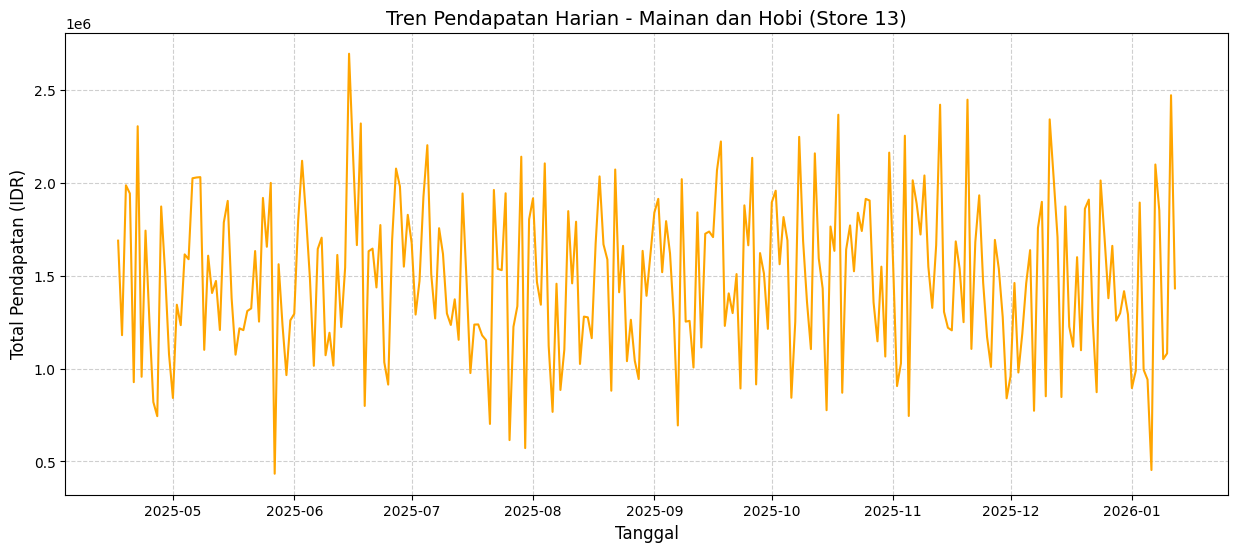

In [10]:
# 1. Tren Pendapatan Harian
plt.figure(figsize=(15, 6))
plt.plot(time_series_hobby.index, time_series_hobby['revenue_clean'], color='orange', linewidth=1.5)
plt.title('Tren Pendapatan Harian - Mainan dan Hobi (Store 13)', fontsize=14)
plt.xlabel('Tanggal', fontsize=12)
plt.ylabel('Total Pendapatan (IDR)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

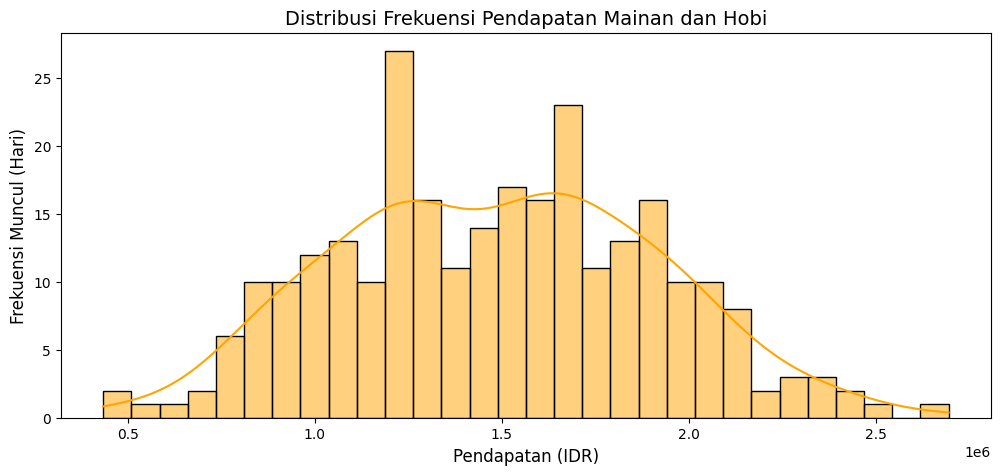

In [11]:
# 2. Distribusi Pendapatan
plt.figure(figsize=(12, 5))
sns.histplot(time_series_hobby['revenue_clean'], kde=True, color='orange', bins=30)
plt.title('Distribusi Frekuensi Pendapatan Mainan dan Hobi', fontsize=14)
plt.xlabel('Pendapatan (IDR)', fontsize=12)
plt.ylabel('Frekuensi Muncul (Hari)', fontsize=12)
plt.show()

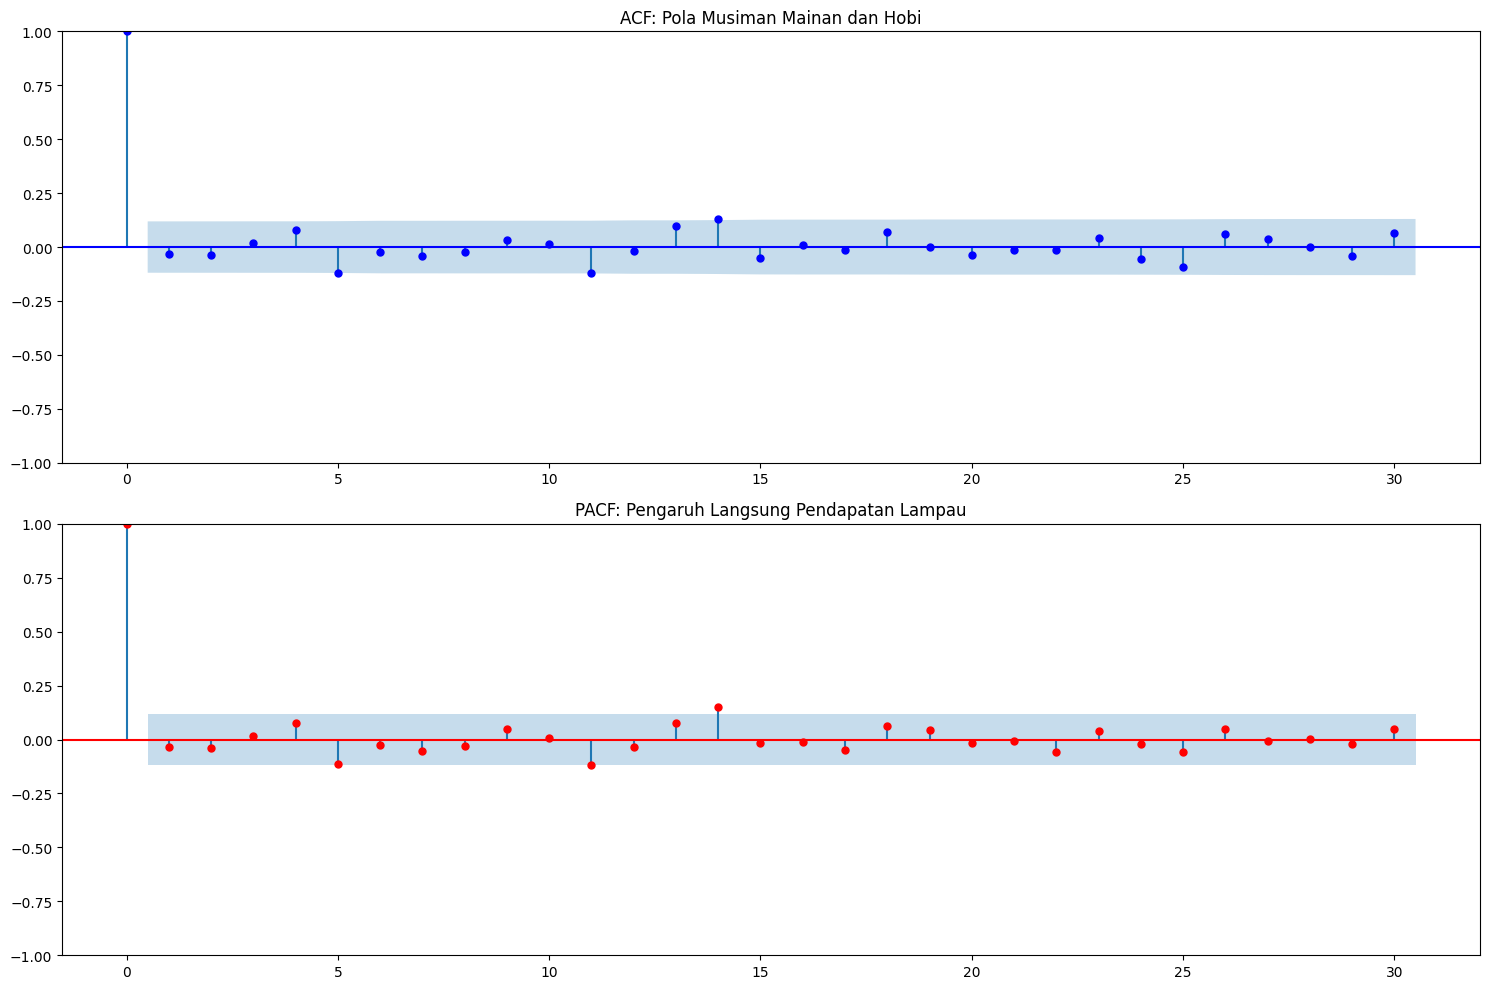

In [12]:
# 3. ACF & PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
plot_acf(time_series_hobby['revenue_clean'], lags=30, ax=ax1, color='blue')
ax1.set_title('ACF: Pola Musiman Mainan dan Hobi', fontsize=12)
plot_pacf(time_series_hobby['revenue_clean'], lags=30, ax=ax2, color='red')
ax2.set_title('PACF: Pengaruh Langsung Pendapatan Lampau', fontsize=12)
plt.tight_layout()
plt.show()

/tmp/ipython-input-834643725.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='day_name', y='revenue_clean', data=time_series_hobby, order=order, palette='YlOrRd')


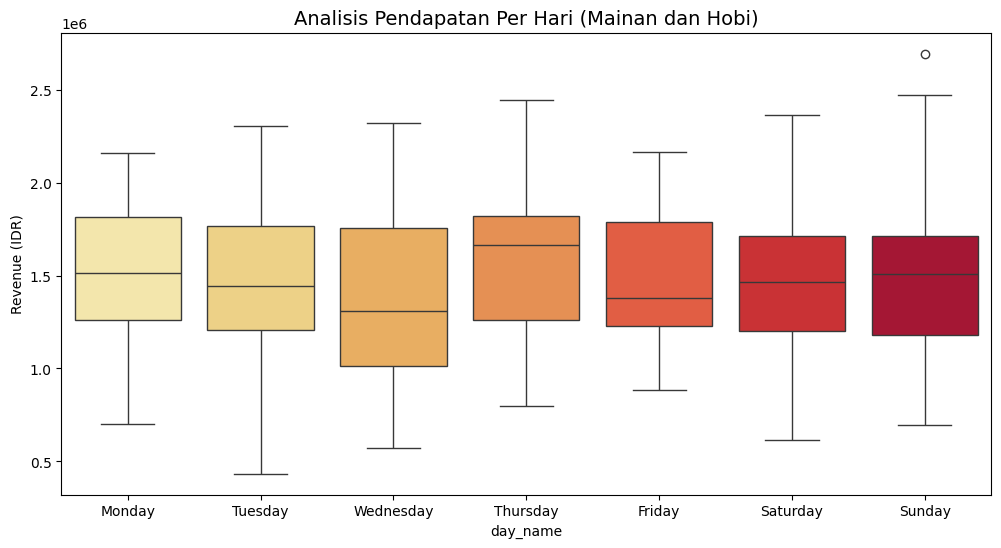

In [13]:
# 4. Boxplot Hari dalam Seminggu
time_series_hobby['day_name'] = time_series_hobby.index.day_name()
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plt.figure(figsize=(12, 6))
sns.boxplot(x='day_name', y='revenue_clean', data=time_series_hobby, order=order, palette='YlOrRd')
plt.title('Analisis Pendapatan Per Hari (Mainan dan Hobi)', fontsize=14)
plt.ylabel('Revenue (IDR)')
plt.show()

In [14]:
# 5. Ringkasan Statistik
stats = time_series_hobby['revenue_clean'].describe()
print("="*45)
print("   RINGKASAN STATISTIK PENDAPATAN MAINAN DAN HOBI")
print("="*45)
print(f"Jumlah Data (Hari)  : {stats['count']:,.0f}")
print(f"Rata-rata Harian    : Rp {stats['mean']:,.2f}")
print(f"Standar Deviasi     : Rp {stats['std']:,.2f}")
print(f"Pendapatan Minimum  : Rp {stats['min']:,.2f}")
print(f"Median (P50)        : Rp {stats['50%']:,.2f}")
print(f"Pendapatan Maksimum : Rp {stats['max']:,.2f}")
print("="*45)

   RINGKASAN STATISTIK PENDAPATAN MAINAN DAN HOBI
Jumlah Data (Hari)  : 271
Rata-rata Harian    : Rp 1,485,448.34
Standar Deviasi     : Rp 422,868.01
Pendapatan Minimum  : Rp 434,000.00
Median (P50)        : Rp 1,508,000.00
Pendapatan Maksimum : Rp 2,695,500.00


# Preprocessing Data

## Feature Engineering

(Menambah Konteks Waktu)

In [15]:
# 1. Feature Engineering
id_holidays = holidays.Indonesia(years=[2025, 2026])
time_series_hobby['is_holiday'] = time_series_hobby.index.strftime('%Y-%m-%d').isin(id_holidays).astype(int)
time_series_hobby['is_payday'] = time_series_hobby.index.day.map(lambda x: 1 if x >= 25 or x <= 5 else 0)
time_series_hobby['is_weekend'] = time_series_hobby.index.weekday.map(lambda x: 1 if x >= 5 else 0)

In [16]:
# Fitur Lag 1-7
for i in range(1, 8):
    time_series_hobby[f'lag_{i}'] = time_series_hobby['revenue_clean'].shift(i)

In [17]:
# Fitur Tren (Rolling Average 7 hari)
time_series_hobby['rolling_avg_7d'] = time_series_hobby['revenue_clean'].rolling(window=7).mean()

In [18]:
# Update Feature Engineering (Menambah Day of Month)
time_series_hobby['day_of_month'] = time_series_hobby.index.day

In [19]:
# Hapus baris yang kosong akibat proses Lag
time_series_hobby.dropna(inplace=True)

## Scaling

In [20]:
# 2. Definisikan X dan y
features = [f'lag_{i}' for i in range(1, 8)] + ['is_holiday', 'is_payday', 'is_weekend', 'rolling_avg_7d', 'day_of_month']
X_raw = time_series_hobby[features]
y_raw = time_series_hobby['revenue_clean']

In [21]:
# 3. Scaling (Mengubah angka jutaan ke skala 0-1)
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

In [22]:
X_scaled = scaler_X.fit_transform(X_raw)
y_scaled = scaler_y.fit_transform(y_raw.values.reshape(-1, 1))

In [23]:
# 4. Reshaping ke format 3D untuk LSTM [Samples, Time Steps, Features]
X_final = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))
y_final = y_scaled

## Splitting Data (Train & Test)

In [24]:
# 5. Split Data (80% Training, 20% Testing)
train_size = int(len(X_final) * 0.8)
X_train, X_test = X_final[:train_size], X_final[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]

print(f"Preprocessing Selesai! Data siap dilatih dengan {X_train.shape[2]} fitur.")

Preprocessing Selesai! Data siap dilatih dengan 12 fitur.


# Modeling

In [25]:
def model_builder(hp):
    model = Sequential()

    # CNN Layer
    model.add(Conv1D(
        filters=hp.Int("conv_filters", 32, 128, 16),
        kernel_size=1, activation='relu',
        input_shape=(X_train.shape[1], X_train.shape[2])
    ))
    model.add(MaxPooling1D(pool_size=1))

    # Bi-LSTM Layer
    model.add(Bidirectional(LSTM(units=hp.Int("bilstm_units", 64, 256, 32), return_sequences=True)))
    model.add(Dropout(hp.Float("dropout_1", 0.1, 0.4, 0.1)))

    # LSTM 2
    model.add(LSTM(units=hp.Int("lstm_units", 32, 128, 32), return_sequences=False))

    model.add(Dense(hp.Int("dense_units", 32, 128, 32), activation='relu'))
    model.add(Dense(1))

    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

# Reset Tuner Khusus Hobby
tuner_path = 'tuner_dir/hobby_tuning'
if os.path.exists(tuner_path):
    shutil.rmtree(tuner_path)

tuner = kt.RandomSearch(
    model_builder,
    objective='val_loss',
    max_trials=10,
    directory='tuner_dir',
    project_name='hobby_tuning',
    overwrite=True
)

early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

print("Memulai Hyperparameter Tuning untuk Mainan dan Hobi...")
tuner.search(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[early_stop], verbose=1)

# Ambil Model Terbaik
best_model = tuner.get_best_models(num_models=1)[0]
print("\nTuning Selesai. Arsitektur model terbaik dipilih.")
best_model.summary()

Trial 10 Complete [00h 00m 20s]
val_loss: 0.016065383329987526

Best val_loss So Far: 0.011550508439540863
Total elapsed time: 00h 03m 44s

Tuning Selesai. Arsitektur model terbaik dipilih.


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 1, 48)          │           624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 1, 48)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 1, 320)         │       267,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 320)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 96)             │       160,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 440,817 (1.68 MB)

 Trainable params: 440,817 (1.68 MB)

 Non-trainable params: 0 (0.00 B)

# Evaluation & Visualization

In [26]:
# 1. Pelatihan Akhir Model Terbaik
print("Melatih model akhir...")
history = best_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=16,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

Melatih model akhir...
Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step - loss: 0.0212 - mae: 0.1202 - val_loss: 0.0255 - val_mae: 0.1301
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0178 - mae: 0.1078 - val_loss: 0.0149 - val_mae: 0.0972
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0084 - mae: 0.0693 - val_loss: 0.0188 - val_mae: 0.1144
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0108 - mae: 0.0850 - val_loss: 0.0133 - val_mae: 0.0973
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0094 - mae: 0.0756 - val_loss: 0.0125 - val_mae: 0.0931
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0085 - mae: 0.0715 - val_loss: 0.0104 - val_mae: 0.0812
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0077 - mae: 0.0683 - val_loss: 0.0092 - val_mae: 0.0788
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0060 - mae: 0.0585 - val_loss: 0.0102 - val_mae: 0.0845
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━

In [27]:
# 2. Prediksi & Kembalikan Skala (Inverse Transform)
y_pred_scaled = best_model.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 499ms/step


In [28]:
# 3. Inverse Scale (Kembalikan ke nilai Rupiah asli)
y_pred = scaler_y.inverse_transform(y_pred_scaled).ravel()
y_actual = scaler_y.inverse_transform(y_test).ravel()

In [29]:
# 4. Hitung Metrik Utama
mae = mean_absolute_error(y_actual, y_pred)
mape = mean_absolute_percentage_error(y_actual, y_pred) * 100
r2 = r2_score(y_actual, y_pred)

In [30]:
print("="*50)
print("     HASIL EVALUASI MODEL MAINAN DAN HOBI (STORE 13)")
print("="*50)
print(f"1. Mean Absolute Error (MAE)  : Rp {mae:,.2f}")
print(f"2. MAPE (Tingkat Error)       : {mape:.2f}%")
print(f"3. R2-Score (Akurasi Model)   : {r2:.4f}")
print("="*50)

     HASIL EVALUASI MODEL MAINAN DAN HOBI (STORE 13)
1. Mean Absolute Error (MAE)  : Rp 104,706.25
2. MAPE (Tingkat Error)       : 8.07%
3. R2-Score (Akurasi Model)   : 0.9172


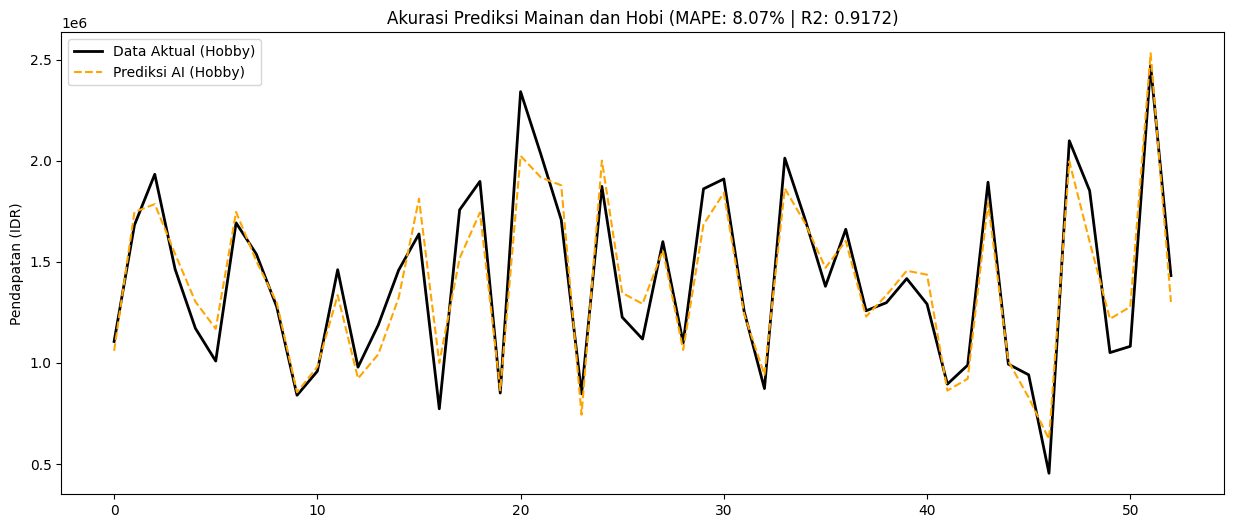

In [31]:
# 4. Visualisasi 1: Prediksi vs Aktual
plt.figure(figsize=(15, 6))
plt.plot(y_actual, label='Data Aktual (Hobby)', color='black', linewidth=2)
plt.plot(y_pred, label='Prediksi AI (Hobby)', color='orange', linestyle='--')
plt.title(f'Akurasi Prediksi Mainan dan Hobi (MAPE: {mape:.2f}% | R2: {r2:.4f})')
plt.ylabel('Pendapatan (IDR)')
plt.legend()
plt.show()

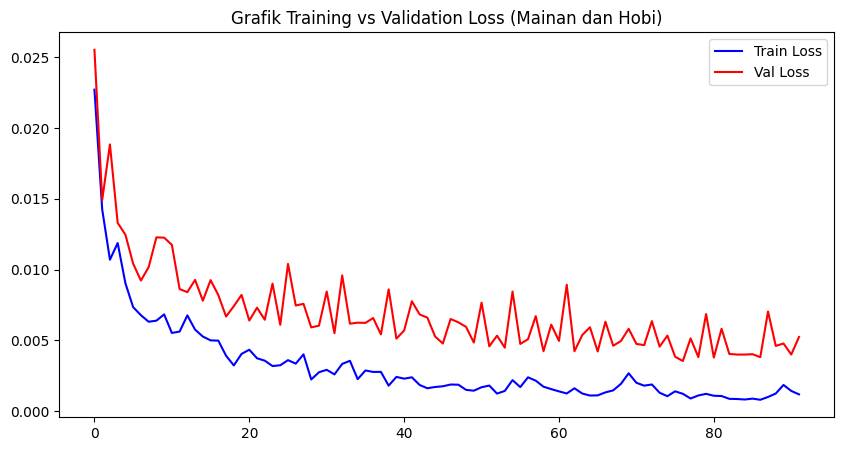

In [32]:
# 5. Visualisasi 2: Loss Curve
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Val Loss', color='red')
plt.title('Grafik Training vs Validation Loss (Mainan dan Hobi)')
plt.legend()
plt.show()

# Save Model

In [33]:
# Simpan Model & Scaler
model_path = '/content/drive/MyDrive/Magang Prima PTKI/models/mainan_hobi/model_hobby_store_13.keras'
os.makedirs(os.path.dirname(model_path), exist_ok=True)
best_model.save(model_path)
joblib.dump(scaler_X, '/content/drive/MyDrive/Magang Prima PTKI/models/mainan_hobi/scaler_X_hobby.pkl')
joblib.dump(scaler_y, '/content/drive/MyDrive/Magang Prima PTKI/models/mainan_hobi/scaler_y_hobby.pkl')

['/content/drive/MyDrive/Magang Prima PTKI/models/mainan_hobi/scaler_y_hobby.pkl']

# Kode Inference Dengan Analisis Bisnis

In [34]:
# 1. Load Model & Scaler
model = load_model('/content/drive/MyDrive/Magang Prima PTKI/models/mainan_hobi/model_hobby_store_13.keras')
scaler_X = joblib.load('/content/drive/MyDrive/Magang Prima PTKI/models/mainan_hobi/scaler_X_hobby.pkl')
scaler_y = joblib.load('/content/drive/MyDrive/Magang Prima PTKI/models/mainan_hobi/scaler_y_hobby.pkl')

In [35]:
def get_forecast_7_days_stabilized_hobby(model, df_historical, scaler_X, scaler_y):
    # Ambil data 7 hari terakhir
    current_lags = df_historical['revenue_clean'].tail(7).tolist()

    # Hitung rata-rata per hari dalam seminggu (Stabilizer)
    weekly_pattern = df_historical.groupby(df_historical.index.dayofweek)['revenue_clean'].mean()

    predictions = []
    dates = []
    last_date = df_historical.index[-1]
    id_holidays = holidays.Indonesia(years=[last_date.year, last_date.year + 1])

    print("="*60)
    print(f"   PREDIKSI OPERASIONAL HOBBY TERSTABILISASI (7 HARI)")
    print(f"   (Batas Data: {last_date.strftime('%d %b %Y')})")
    print("="*60)

    for i in range(1, 8):
        current_date = last_date + timedelta(days=i)
        day_idx = current_date.weekday()

        # Fitur Engineering
        is_holiday = 1 if current_date.strftime('%Y-%m-%d') in id_holidays else 0
        is_payday = 1 if current_date.day >= 25 or current_date.day <= 5 else 0
        is_weekend = 1 if day_idx >= 5 else 0
        rolling_avg = np.mean(current_lags)
        day_of_month = current_date.day

        # Susun fitur (12 fitur)
        input_row = current_lags + [is_holiday, is_payday, is_weekend, rolling_avg, day_of_month]

        # Scaling & Prediksi
        input_scaled = scaler_X.transform([input_row])
        input_final = input_scaled.reshape((1, 1, len(features)))
        pred_scaled = model.predict(input_final, verbose=0)
        raw_pred = scaler_y.inverse_transform(pred_scaled)[0][0]

        # --- LOGIKA "REM" (STABILIZER) ---
        avg_hist_day = weekly_pattern[day_idx]
        stabilized_pred = (raw_pred * 0.7) + (avg_hist_day * 0.3)

        # Clipping: Jangan biarkan melebihi 120% dari nilai maksimum historis
        max_limit = df_historical['revenue_clean'].max() * 1.2
        final_pred = min(stabilized_pred, max_limit)

        predictions.append(final_pred)
        dates.append(current_date)

        # Update Lags untuk iterasi berikutnya
        current_lags.pop(0)
        current_lags.append(final_pred)

        # Status berdasarkan rata-rata statistik toko hobi
        status = "RAMAI" if final_pred > stats['mean'] * 1.1 else "NORMAL"
        print(f"{current_date.strftime('%A, %d %b')}: Rp {final_pred:,.0f} | {status}")

    return pd.DataFrame({'date': dates, 'pred_revenue': predictions}).set_index('date')

In [36]:
# Jalankan Proyeksi Baru untuk Hobby
forecast_results_hobby = get_forecast_7_days_stabilized_hobby(best_model, time_series_hobby, scaler_X, scaler_y)

   PREDIKSI OPERASIONAL HOBBY TERSTABILISASI (7 HARI)
   (Batas Data: 12 Jan 2026)
Tuesday, 13 Jan: Rp 1,339,409 | NORMAL


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Wednesday, 14 Jan: Rp 1,421,285 | NORMAL
Thursday, 15 Jan: Rp 1,399,855 | NORMAL
Friday, 16 Jan: Rp 816,297 | NORMAL


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Saturday, 17 Jan: Rp 1,187,313 | NORMAL
Sunday, 18 Jan: Rp 1,446,383 | NORMAL
Monday, 19 Jan: Rp 1,368,822 | NORMAL


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


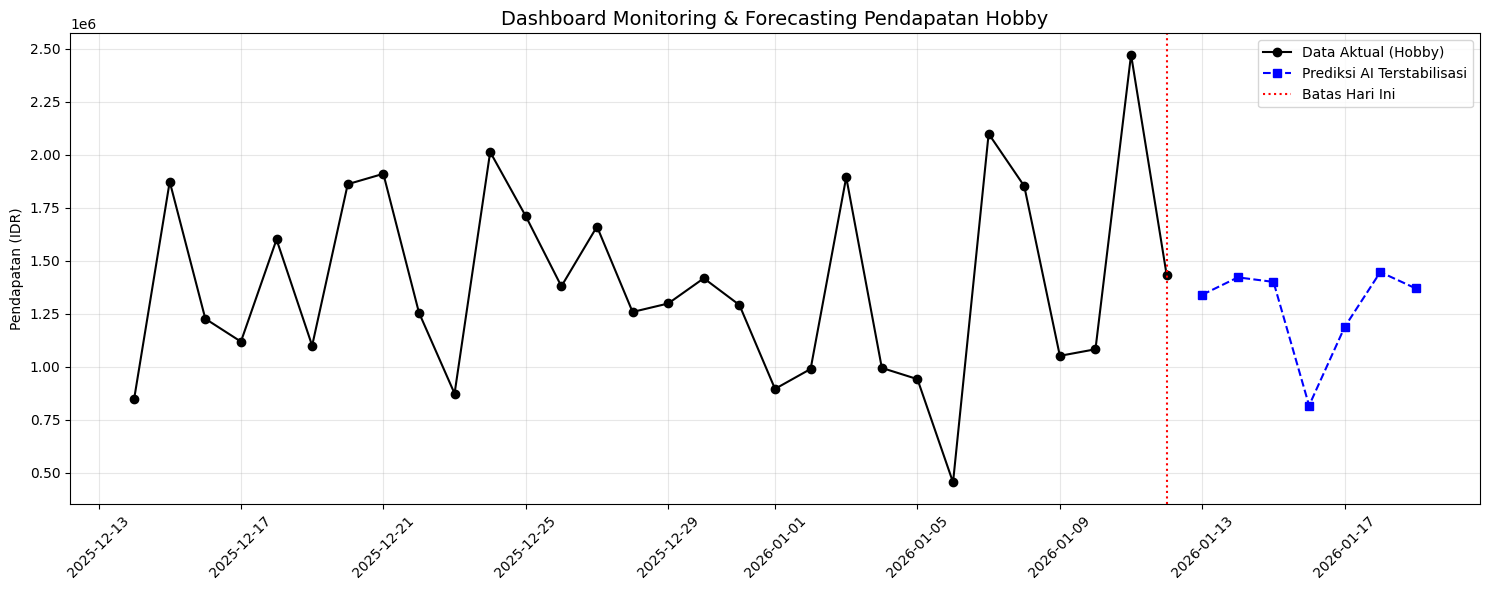

In [37]:
# Visualisasi Dashboard Hobby
plt.figure(figsize=(15, 6))
hist_data_hobby = time_series_hobby.tail(30)

plt.plot(hist_data_hobby.index, hist_data_hobby['revenue_clean'],
         label='Data Aktual (Hobby)', color='black', marker='o')

plt.plot(forecast_results_hobby.index, forecast_results_hobby['pred_revenue'],
         label='Prediksi AI Terstabilisasi', color='blue', linestyle='--', marker='s')

plt.axvline(x=hist_data_hobby.index[-1], color='red', linestyle=':', label='Batas Hari Ini')
plt.title('Dashboard Monitoring & Forecasting Pendapatan Hobby', fontsize=14)
plt.ylabel('Pendapatan (IDR)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()